In [ ]:
import torch
import string
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

WORD = "word"    # Token text
POS = "pos"      # Part-of-speech tag
HEAD = "head"    # Index of dependency head
SEQ_LEN = "seq_len"  # Length of sequence


class Vocabulary:
    """Vocabulary class for mapping tokens to indices. Handles token frequency filtering and vocabulary size limits."""

    def __init__(self, min_freq=1, max_size=None):

       """
        Initializing vocabulary with special tokens.

        Args:
            min_freq (int): Minimum frequency required to include a token
            max_size (int, optional): Maximum vocabulary size (excluding special tokens)
        """
       self.word2idx = {'<pad>': 0, '<unk>': 1}
       self.idx2word = {0: '<pad>', 1: '<unk>'}
       self.word_freq = {}
       self.min_freq = min_freq
       self.max_size = max_size

    def add(self, word):
        """
        Adds words to the frequency counter.

        Args:
            word (str): Word to add
        """
        if word not in self.word_freq:
            self.word_freq[word] = 0
        self.word_freq[word] += 1

    def build(self):

        """
        Builds the vocabulary from collected frequencies.
        Words are sorted by frequency (descending) and filtered by minimum frequency.

        """
        sorted_words = sorted(
            self.word_freq.items(),
            key=lambda x: x[1],
            reverse=True
        )
        idx = len(self.word2idx)
        for word, freq in sorted_words:
            if freq < self.min_freq:
                continue
            if self.max_size and idx >= self.max_size:
                break
            self.word2idx[word] = idx
            self.idx2word[idx] = word
            idx += 1

    def __getitem__(self, item):
        """
        Gives index for a word, returning <unk> index if not found.

        Args:
            item (str): Word to look up

        Returns:
            int: Index of the word or the <unk> index
        """
        return self.word2idx.get(item, self.word2idx['<unk>'])

    def __len__(self):
        """Gives vocabulary size."""

        return len(self.word2idx)

    def get_contents(self):
        """Returning internal mappings."""

        return self.word2idx, self.idx2word


class ConllLoader:
    """Loader for CoNLL-U formatted data."""

    def __init__(self, fields, indexes):
        """
        Initialize with field names and their corresponding column indexes.

        Args:
            fields (list): List of field names
            indexes (list): List of column indexes in the CoNLL format
        """
        self.fields = fields
        self.indexes = indexes

    def load(self, file_path):
        """Load CoNLL-U data with error handling.
           Args:
            file_path (str): Path to CoNLL-U file

           Returns:
            list: List of sentences, where each sentence is a list of token dictionaries
        """
        import pyconll  # Import here to avoid dependency issues if unused.

        data = []
        try:
            conll = pyconll.load_from_file(file_path)
            for sentence in conll:
                valid_sentence = []
                for token in sentence:
                    if not all([token.form, token.upos, token.head]):
                        continue
                    entry = {
                        WORD: token.form,
                        POS: token.upos,
                        HEAD: int(token.head) if token.head.isdigit() else 0,
                    }
                    valid_sentence.append(entry)
                if valid_sentence:
                    data.append(valid_sentence)
        except Exception as e:
            print(f"Error parsing {file_path}: {e}")

        return data


class SimpleDataModule:
    """Data module for preprocessing and loading dependency parsing data."""

    def __init__(self,
                 train_file,
                 val_file,
                 test_file,
                 device='cpu',
                 batch_size=8,
                 vocab_type='min_freq',
                 min_freq=1,
                 vocab_size=None):

        """
        Data module for preprocessing and loading dependency parsing data.
        Handles data loading, cleaning, and vocabulary creation.
        """
        self.train_file = train_file
        self.val_file = val_file
        self.test_file = test_file
        self.device = device

        self.batch_size = batch_size
        self.vocab_type = vocab_type
        self.min_freq = min_freq
        self.vocab_size = vocab_size

        # Prepare datasets and vocabularies
        self.prepare_datasets()

    def clean_word(self, words):
        """
        Cleans words by removing punctuation and normalizing numbers.

        Args:
            words (list): List of words to clean

        Returns:
            list: List of cleaned words
        """
        translator = str.maketrans('', '', string.punctuation)
        cleaned = []
        for word in words:
            cleaned.append(word.translate(translator))
        return ['0' if word.replace('.', '', 1).isdigit() else word for word in cleaned]


    def prepare_datasets(self):
        """
          Prepares datasets by loading, filtering, cleaning, and building vocabularies.
          Sets up train, validation, and test datasets with consistent processing.
        """
        loader = ConllLoader(fields=[WORD, POS, HEAD], indexes=[1, 3, 6])

        # Load datasets
        train_data = loader.load(self.train_file)
        val_data = loader.load(self.val_file)
        test_data = loader.load(self.test_file)

        # Filter out empty sentences
        train_data = [
            sentence for sentence in loader.load(self.train_file)
            if 0 < len(sentence) <= 10
        ]

        val_data = [
            sentence for sentence in loader.load(self.val_file)
            if 0 < len(sentence) <= 10
        ]

        test_data = [
            sentence for sentence in loader.load(self.test_file)
            if 0 < len(sentence) <= 10
        ]

        # Clean words, add sequence length, and convert head fields
        for dataset in [train_data, val_data, test_data]:
            for sentence in dataset:
                words = [entry[WORD] for entry in sentence]
                cleaned_words = self.clean_word(words)

                for i, entry in enumerate(sentence):
                    entry[WORD] = cleaned_words[i]

                # Add sequence length
                for entry in sentence:
                    entry[SEQ_LEN] = len(sentence)

        # Convert head fields to integers
        for sentence in test_data:
            for entry in sentence:  # Iterate over word entries
                entry[HEAD] = int(entry[HEAD]) if isinstance(entry[HEAD], str) and entry[HEAD].isdigit() else 0

        # Build vocabularies
        self.word_vocab = Vocabulary(min_freq=self.min_freq, max_size=self.vocab_size)
        self.pos_vocab = Vocabulary()

        for sentence in train_data:  # Build vocab using training data only.
            for entry in sentence:
                self.word_vocab.add(entry[WORD])
                self.pos_vocab.add(entry[POS])

        # Finalize vocabulary building.
        self.word_vocab.build()
        self.pos_vocab.build()

        # Set vocab size to actual size
        self.vocab_size = len(self.word_vocab)

        # Store processed datasets.
        self.train_dataset = train_data
        self.val_dataset = val_data
        self.test_dataset = test_data


class ConllDataset(Dataset):
    """Dataset wrapper for CoNLL dependency parsing data."""

    def __init__(self, sentences, word_vocab, pos_vocab):
        """
        Initializes the dataset.

        Args:
            sentences: List of sentences (each sentence is a list of tokens).
            word_vocab: Vocabulary for words.
            pos_vocab: Vocabulary for POS tags.
        """
        self.sentences = sentences
        self.word_vocab = word_vocab
        self.pos_vocab = pos_vocab

    def __len__(self):

       """Returns the number of sentences in the dataset."""
       return len(self.sentences)

    def __getitem__(self, idx):
        """
          Gets a sentence by index, converted to tensor indices.

          Args:
              idx (int): Sentence index

          Returns:
              dict: Dictionary of tensors for words, POS tags, heads, and sequence length
          """

        sentence = self.sentences[idx]

        words = [token[WORD] for token in sentence]
        pos_tags = [token[POS] for token in sentence]
        heads = [token[HEAD] for token in sentence]

        word_indices = [self.word_vocab[word] for word in words]
        pos_indices = [self.pos_vocab[pos] for pos in pos_tags]

        return {
            WORD: torch.tensor(word_indices, dtype=torch.long),
            POS: torch.tensor(pos_indices, dtype=torch.long),
            HEAD: torch.tensor(heads, dtype=torch.long),
            SEQ_LEN: torch.tensor(len(sentence), dtype=torch.long),
        }


def custom_collate_fn(batch):
    """Custom collate function to handle padding.
    Pads sequences to the longest sequence in the batch.

    Args:
        batch (list): List of dictionaries containing tensors

    Returns:
        dict: Dictionary of batched tensors with padding
    """
    #print("Batch before padding:", batch[0])
    result = {WORD: [], POS: [], HEAD: [], SEQ_LEN: []}

    for sample in batch:
        result[WORD].append(sample[WORD])
        result[POS].append(sample[POS])
        result[HEAD].append(sample[HEAD])
        result[SEQ_LEN].append(sample[SEQ_LEN])

    result[SEQ_LEN] = torch.stack(result[SEQ_LEN])

    result[WORD] = pad_sequence(result[WORD], batch_first=True, padding_value=0)
    result[POS] = pad_sequence(result[POS], batch_first=True, padding_value=0)
    result[HEAD] = pad_sequence(result[HEAD], batch_first=True, padding_value=-1)

    return result


def create_dataloaders(data_module):
    """Create PyTorch DataLoaders from the data module.
       Sets up train, validation, and test loaders with appropriate settings.

    Args:
        data_module (SimpleDataModule): Data module with processed datasets

    Returns:
        tuple: Train, validation, and test DataLoader objects

    """
    train_dataset = ConllDataset(data_module.train_dataset,
                                 data_module.word_vocab,
                                 data_module.pos_vocab)

    val_dataset = ConllDataset(data_module.val_dataset,
                               data_module.word_vocab,
                               data_module.pos_vocab)

    test_dataset = ConllDataset(data_module.test_dataset,
                                data_module.word_vocab,
                                data_module.pos_vocab)

    train_loader = DataLoader(train_dataset,
                              batch_size=data_module.batch_size,
                              shuffle=True,
                              collate_fn=custom_collate_fn)

    val_loader = DataLoader(val_dataset,
                            batch_size=data_module.batch_size,
                            shuffle=False,
                            collate_fn=custom_collate_fn)

    test_loader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             collate_fn=custom_collate_fn)

    return train_loader, val_loader, test_loader

# Testing code
if __name__ == "__main__":
    data_module = SimpleDataModule(
        train_file="en_ewt-ud-train.conllu",
        val_file="en_ewt-ud-dev.conllu",
        test_file="en_ewt-ud-test.conllu",
    )

    train_loader, val_loader, test_loader = create_dataloaders(data_module)

    # Test a batch.
    for batch in train_loader:
        print(f"Batch word shape: {batch[WORD].shape}")
        print(f"Batch pos shape: {batch[POS].shape}")
        print(f"Batch head shape: {batch[HEAD].shape}")
        print(f"Batch seq_len shape: {batch[SEQ_LEN].shape}")
        break


Batch word shape: torch.Size([8, 9])
Batch pos shape: torch.Size([8, 9])
Batch head shape: torch.Size([8, 9])
Batch seq_len shape: torch.Size([8])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Biaffine(nn.Module):
    """
    Biaffine attention module for scoring dependencies between words.
    """
    def __init__(self, in1_features, in2_features, out_features=1, bias_x=True, bias_y=True):
        """
        Initialize the biaffine transformation module.

          Args:
              in1_features (int): Dimension of first input features (usually head representations)
              in2_features (int): Dimension of second input features (usually dependent representations)
              out_features (int): Dimension of output features (usually 1 for arc scoring)
              bias_x (bool): Whether to add bias to the first input
              bias_y (bool): Whether to add bias to the second input
          """
        super().__init__()
        self.bias_x = bias_x
        self.bias_y = bias_y
        self.in1_features = in1_features + int(bias_x)
        self.in2_features = in2_features + int(bias_y)
        self.out_features = out_features

        # # Weight tensor of shape (out_features, in1_features, in2_features)
        self.weight = nn.Parameter(
            torch.Tensor(self.out_features, self.in1_features, self.in2_features)
        )
        self.reset_parameters()

    def reset_parameters(self):
        """Initialize weights with Xavier uniform distribution for stable training"""

        nn.init.xavier_uniform_(self.weight)

    def forward(self, x, y):
        """
        Apply biaffine transformation on input tensors x and y.

          Args:
              x (Tensor): First input tensor of shape (batch_size, seq_len, in1_features)
              y (Tensor): Second input tensor of shape (batch_size, seq_len, in2_features)

          Returns:
              Tensor: Biaffine scores of shape (batch_size, seq_len, seq_len)
          x, y = x.to(self.weight.device), y.to(self.weight.device)
        """

        if self.bias_x:
            x = torch.cat([x, torch.ones_like(x[..., :1])], dim=-1)
        if self.bias_y:
            y = torch.cat([y, torch.ones_like(y[..., :1])], dim=-1)

        #print(f"\nBiaffine debug:")
        #print(f"x shape: {x.shape}, y shape: {y.shape}")
        #print(f"Weight shape: {self.weight.shape}")

        #scores = torch.einsum('bxi,oij,byj->boxy', x, self.weight, y)
        scores = torch.einsum('bxi,oij,byj->bxy', x, self.weight, y)
        #print(f"Biaffine output shape: {scores.shape}")
        return scores.squeeze(1)

class NDMV_Biaffine(nn.Module):
    """
      Neural Dependency Model with Valence using Biaffine attention.
    """
    def __init__(self, pos_vocab, pos_emb_size=100, hidden_size=256, dropout_rate=0.3, device='cpu'):
            """
            Initialize the NDMV model with biaffine attention.

            Args:
                pos_vocab (dict): Mapping of POS tags to indices
                pos_emb_size (int): Dimension of POS embeddings
                hidden_size (int): Dimension of hidden layers
                dropout_rate (float): Dropout probability for regularization
                device (str): Device to place the model for GPU usage
            """
            super().__init__()
            self.device = device
            self.num_pos = len(pos_vocab)
            self.pos_emb_size = pos_emb_size
            self.hidden_size = hidden_size

            # Embeddings for POS tags
            self.pos_emb = nn.Embedding(self.num_pos, self.pos_emb_size).to(device)
            # Valence embeddings (HASCHILD, NOCHILD)
            self.val_emb = nn.Parameter(torch.randn(2, self.pos_emb_size, device=device))
            # Embedding for the root token
            self.root_emb = nn.Parameter(torch.randn(1, self.pos_emb_size, device=device))

            # Regularization and activation
            self.dropout = nn.Dropout(dropout_rate)
            self.relu = nn.ReLU()

            # Projection layers for head and dependent representations. The size is of concatenated POS and valence embeddings
            self.mlp_head = nn.Linear(2 * self.pos_emb_size, self.hidden_size)
            self.mlp_dep = nn.Linear(2 * self.pos_emb_size, self.hidden_size)

            # Biaffine scorer for arc scoring between head and dependent
            self.arc_biaffine = Biaffine(
              in1_features=2 * hidden_size,  # 2 valences
              in2_features=2 * hidden_size,
              out_features=1,
              bias_x=True,
              bias_y=True
          ).to(device)

            # Decision scorer: Predicts decision logits for different combinations of direction, valence, and binary decision
            self.decision_mlp = nn.Sequential(
            nn.Linear(4 * pos_emb_size, hidden_size),  # 2 valences * 2 pos_emb_size
            nn.ReLU(),
            nn.Linear(hidden_size, 8)  # 2 directions × 2 valences × 2 decisions
            ).to(device)

            # Root scorer which predicts which POS tag is likely to be the root
            self.root_mlp = nn.Sequential(
                nn.Linear(self.pos_emb_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, self.num_pos)
            ).to(device)

            self.to(device)

    def forward(self, batch):
      """
      Forward pass of the NDMV model.

      Args:
          batch (dict)

      Returns:
          dict: Contains attachment probabilities, decision probabilities, and root probabilities
      """
      x = batch['pos'].to(self.device)
      batch_size, seq_len = x.shape

      # POS embeddings
      pos_embed = self.pos_emb(x)

      # Expanding valence embeddings for all words in all sentences
      val_embed = self.val_emb.unsqueeze(0).unsqueeze(0).expand(batch_size, seq_len, 2, -1)

      # Combine embeddings
      emb = torch.cat([pos_embed.unsqueeze(2).expand(batch_size, seq_len, 2, -1), val_embed], dim=-1)
      emb = self.dropout(emb)

      # Biaffine scores with valence
      #arc_scores = self.arc_biaffine(head_repr.unsqueeze(2), dep_repr.unsqueeze(1))

      # Head/dependent representations
      head_repr = self.mlp_head(emb)
      dep_repr = self.mlp_dep(emb)

      #print(f"Head representation shape: {head_repr.shape}")
      #print(f"Dependent representation shape: {dep_repr.shape}")

      # Flattening valence+features dimensions
      head_repr = head_repr.flatten(start_dim=2)
      dep_repr = dep_repr.flatten(start_dim=2)

      # Getting arc score
      arc_scores = self.arc_biaffine(head_repr, dep_repr)

      # Left mask: lower triangular matrix without diagonal (dependent < head)
      left_mask = torch.tril(torch.ones(seq_len, seq_len, device=self.device), diagonal=-1)
      # Right mask: upper triangular matrix without diagonal (dependent > head)
      right_mask = torch.triu(torch.ones(seq_len, seq_len, device=self.device), diagonal=1)

      # Expanding masks to match batch size
      left_mask = left_mask.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq, seq]
      right_mask = right_mask.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq, seq]

      # Applying masks to arc_scores
      left_scores = arc_scores * left_mask + (1 - left_mask) * -1e9
      right_scores = arc_scores * right_mask + (1 - right_mask) * -1e9

      # Converting to log probabilities
      left_log_probs = F.log_softmax(left_scores, dim=-1)
      right_log_probs = F.log_softmax(right_scores, dim=-1)


      emb_flat = emb.view(batch_size, seq_len, -1)  # Reshaping for the MLPs

      # Passing the embeddings through the decision_mlp
      decision_logits = self.decision_mlp(emb_flat)

      decision_log_probs = decision_logits.view(batch_size, seq_len, 2, 2, 2).log_softmax(-1)

      # Doing the same for root logits from MLP_root
      root_logits = self.root_mlp(self.root_emb)
      root_log_probs = F.log_softmax(root_logits, dim=-1)
      root_probs = root_log_probs.expand(batch_size, self.num_pos).gather(-1, x)

      # Returning dictionary with left and right attach probabilities stacked together.
      return {
          'attach': torch.stack([left_log_probs, right_log_probs], dim=-1),
          'decision': decision_log_probs,
          'root': root_probs
      }


In [ ]:
## Trial function only
def run_ndmv_biaffine(train_file, val_file, test_file):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Loading the data
    data_module = SimpleDataModule(train_file, val_file, test_file)
    train_loader, _, _ = create_dataloaders(data_module)

    # Initializing the model
    model = NDMV_Biaffine(pos_vocab=data_module.pos_vocab, device=device)
    model.to(device)

    # Running one batch through the model
    batch = next(iter(train_loader))
    batch = {key: val.to(device) for key, val in batch.items()}
    output = model(batch)

    # and printing results
    print("Attach Log Probs:", output['attach'].shape)
    print("Decision Log Probs:", output['decision'].shape)
    print("Root Probs:", output['root'].shape)

run_ndmv_biaffine("en_ewt-ud-train.conllu", "en_ewt-ud-dev.conllu", "en_ewt-ud-test.conllu")


Attach Log Probs: torch.Size([8, 8, 8, 2])
Decision Log Probs: torch.Size([8, 8, 2, 2, 2])
Root Probs: torch.Size([8, 8])


In [ ]:
'''
The idea of this implementation is done with the help of the DMV eisner function.
Ref: https://github.com/sustcsonglin/second-order-neural-dmv/blob/main/parser/dmvs/dmv.py
'''


@torch.enable_grad()
def NDMV_inside(rules, device, lens=None):

    """
    Compute the inside chart for the NDMV model using dynamic programming.

    Args:
        rules (dict): Dictionary containing scores from the neural model:
            - 'attach': Arc attachment scores [batch, seq_len, seq_len, valence]
            - 'decision': Decision scores [batch, seq_len, direction, valence, decision]
            - 'root': Root scores [batch, seq_len]
        device (str): Device to place tensors on for GPU usage
        lens (Tensor, optional): Tensor containing actual sequence lengths. Default: None

    Returns:
        dict: Gradients with respect to model parameters and partition function
    """

    ## contants
    huge = -1e30
    NOCHILD = 0
    HASCHILD = 1
    LEFT = 0
    RIGHT = 1
    GO = 0     # Index for decision to continue taking dependents
    STOP = 1   # Index for decision to stop taking dependents
    DIRECTION_NUM = 2
    VALENCE_NUM = 2
    DECISION_NUM = 2
    A = 0  # Index for span viewed from left side
    B = 1  # Index for span viewed from right side
    L = 0  # Index for left attachments
    R = 1  # Index for right attachments
    I = 0  # Index for incomplete spans
    C = 1  # Index for complete spans
    # Catches scores from the model
    attach_score = rules['attach'].requires_grad_()
    decision_score = rules['decision'].requires_grad_()
    root_score = rules['root'][:, 0].requires_grad_()


    b, N, *_ = attach_score.shape

    if lens is None:
        lens = torch.zeros(b, device=device, dtype=torch.long).fill_(N)
    else:
        lens = lens.to(device)
    N += 1  # Accounting for root token at position 0


    # Initializing score tensors
    attach = torch.zeros(b, N, N, VALENCE_NUM, device=device).fill_(huge)
    decision = torch.zeros(b, N, DIRECTION_NUM, VALENCE_NUM, DECISION_NUM, device=device).fill_(huge)

    # For ROOT of position 0, with dependents only to the right and 0 valence, the neural model's root score is fed
    attach[:, 0, 1:, NOCHILD] = root_score.unsqueeze(1).expand(-1, N-1)
    # Normal attachment scores for all real words (non-ROOT)
    attach[:, 1:, 1:, :] = attach_score

    # ROOT symbol is leftmost and can only take dependents to the right
    decision[:, 0, RIGHT, NOCHILD, GO] = 0        # Has to take a dependent (prob=1)
    decision[:, 0, RIGHT, NOCHILD, STOP] = -1e30  # Must not stop before taking one (prob≈0)
    decision[:, 0, RIGHT, HASCHILD, STOP] = 0     # has to stop after taking one (prob=1)
    decision[:, 0, RIGHT, HASCHILD, GO] = -1e30   # Must not take more than one (prob≈0)
    decision[:, 1:] = decision_score #  Assigns the neural model's decision scores to all real words in the sentence (positions 1 and onward)

    # Chart initialization
    alpha = [[[torch.zeros(b, N, N, VALENCE_NUM, device=device).fill_(huge)
              for _ in range(2)] for _ in range(2)] for _ in range(2)]

    # Base cases (now with corrected valence order)
    alpha[A][C][L][:, :, 0, :] = decision[:, :, LEFT, :, STOP]
    alpha[B][C][L][:, :, -1, :] = decision[:, :, LEFT, :, STOP]
    alpha[A][C][R][:, :, 0, :] = decision[:, :, RIGHT, :, STOP]
    alpha[B][C][R][:, :, -1, :] = decision[:, :, RIGHT, :, STOP]

    # Chart filling (unchanged but now with correct valence semantics)
    for k in range(1, N):
        f = torch.arange(N - k), torch.arange(k, N)  # Index pairs for heads and dependents
        ACL = alpha[A][C][L][:, : N - k, :k]  # Left-complete spans from left side
        ACR = alpha[A][C][R][:, : N - k, :k]  # Right-complete spans from left side
        BCL = alpha[B][C][L][:, k:, N - k:]   # Left-complete spans from right side
        BCR = alpha[B][C][R][:, k:, N - k :]  # Right-complete spans from right side

        # Find optimal splitting point
        x = torch.max(ACR[..., NOCHILD, None] + BCL[..., HASCHILD, None], dim=2)[0]
        # Create left arcs dep <- head
        arcs_l = x + attach[:, f[1], f[0], :] + decision[:, f[1], LEFT, :, GO]
        alpha[A][I][L][:, : N - k, k] = arcs_l  # Stores scores for left-side view of spans with size k
        alpha[B][I][L][:, k:N, N - k - 1] = arcs_l  # Stores the same scores but indexed for right-side access

        #Similarly for right arcs head -> dep
        x = torch.max(ACR[..., HASCHILD, None] + BCL[..., NOCHILD, None], dim=2)[0]
        arcs_r = x + attach[:, f[0], f[1], :] + decision[:, f[0], RIGHT, :, GO]
        alpha[A][I][R][:, : N - k, k] = arcs_r
        alpha[B][I][R][:, k:N, N - k - 1] = arcs_r


        AIR = alpha[A][I][R][:, : N - k, 1 : k + 1] #Right incomplete spans
        BIL = alpha[B][I][L][:, k:, N - k - 1 : N - 1] #Left incomplete spans

        # Complete left spans by combining left complete from left side and left-incomplete from right side
        new = torch.max(ACL[..., NOCHILD, None] + BIL, dim=2)[0]
        alpha[A][C][L][:, : N - k, k] = new #Stored for all batches for head positions from 0 - N-k-1 and all spans of size k
        alpha[B][C][L][:, k:N, N - k - 1] = new

        new = torch.max(AIR + BCR[..., NOCHILD, None], dim=2)[0]
        alpha[A][C][R][:, : N - k, k] = new
        alpha[B][C][R][:, k:N, N - k - 1] = new

    # Get log partition function which is the sum of all parse probabilities
    logZ = torch.gather(alpha[A][C][R][:, 0, :, NOCHILD], -1, lens.unsqueeze(-1))


   # Computing gradients, representing the expected counts of each rule, for the backward pass of marginal inference.
    grad_attach, = torch.autograd.grad(
        logZ.sum(),
        [attach_score],
        retain_graph=True,
        create_graph=True
    )
    grad_decision, = torch.autograd.grad(
        logZ.sum(),
        [decision_score],
        retain_graph=True,
        create_graph=True
    )
    grad_root, = torch.autograd.grad(
        logZ.sum(),
        [root_score],
        retain_graph=True
    )

    # Return gradients and partition function
    return {
        'attach_grad': grad_attach.detach(),
        'decision_grad': grad_decision.detach(),
        'root_grad': grad_root.detach(),
        'partition': logZ.detach()
    }


In [ ]:
def train_em(model, dataloader, optimizer, device, evaluate=False):

    """
      Trains or evaluates a neural dependency model using the Expectation-Maximization algorithm.

      Args:
          model: The neural dependency model to train or evaluate
          dataloader: DataLoader providing batches of dependency parsing data
          optimizer: PyTorch optimizer for parameter updates
          device: Device to run computations on
          evaluate: Boolean flag indicating evaluation mode (True) or training mode (False)

      Returns:
          float: Average loss across all batches
      """

    # Creates a learning rate scheduler that reduces LR when validation loss plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

    # Evaluation mode
    if evaluate:
        model.eval()  # Set model to evaluation mode
        total_loss = 0

        with torch.no_grad():  # Disable gradient computation
              for batch in dataloader:
                  x = batch['pos'].to(device)

                  # Forward pass to get attachment, root and decision scores from the model
                  scores = model(batch)
                  rules = {
                      'attach': scores['attach'],
                      'decision': scores['decision'],
                      'root': scores['root']
                  }

                  # E-step: Computes expected counts using inside algorithm
                  inside_result = NDMV_inside(rules, device, lens=batch.get('lengths'))
                  expected_counts = {
                      'attach': inside_result['attach_grad'],
                      'decision': inside_result['decision_grad'],
                      'root': inside_result['root_grad']
                  }

                  # M-step: Compute negative log-liklihood loss
                  # The loss is the negative sum of expected counts times log probabilities
                  loss = (
                      -(expected_counts['attach'] * rules['attach']).sum()
                      -(expected_counts['decision'] * rules['decision']).sum()
                      -(expected_counts['root'] * rules['root'][:, 0]).sum()
                  ) / x.size(0) # Normalizes by batch size

                  total_loss += loss.item()  # Accumulates the loss value

        avg_loss = total_loss / len(dataloader) # Averaging it by the number of sentences

        return avg_loss  # Return validation loss when evaluate=True

    # Training Mode
    model.train()
    total_loss = 0

    for batch in dataloader:
            optimizer.zero_grad()
            x = batch['pos'].to(device)

            # Forward pass
            scores = model(batch)
            rules = {
                'attach': scores['attach'],
                'decision': scores['decision'],
                'root': scores['root']
            }

            # E-step
            inside_result = NDMV_inside(rules, device, lens=batch.get('lengths'))
            expected_counts = {
                'attach': inside_result['attach_grad'],
                'decision': inside_result['decision_grad'],
                'root': inside_result['root_grad']
            }

            # M-step: Compute loss
            loss = (
                -(expected_counts['attach'] * rules['attach']).sum()
                -(expected_counts['decision'] * rules['decision']).sum()
                -(expected_counts['root'] * rules['root'][:, 0]).sum()
            ) / x.size(0)

            # Backpropagation and update
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=4.5)
            optimizer.step()

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)

    # Adjusts learning rate based on the average loss
    scheduler.step(avg_loss)


    return avg_loss  # Returns training loss


Decoding and UAS Evaluation


In [ ]:
import numpy as np
import networkx as nx

from ufal.chu_liu_edmonds import chu_liu_edmonds
def decode(rules, lengths, device):
    """
      Decodes the most probable dependency parse trees from attachment scores using the
      Chu-Liu-Edmonds maximum spanning tree algorithm.

      Args:
          rules (dict): Dictionary containing neural network output scores
              - 'attach': Tensor of shape [batch_size, seq_len, seq_len, valence] with attachment scores
          lengths (Tensor): Tensor containing the actual lengths of each sequence in the batch
          device (str): Device to place output tensor

      Returns:
          dict: Dictionary containing the predicted dependency arcs as a tensor of shape [batch_size, seq_len]
      """
    # Extract scores and convert to float64
    scores = rules['attach'][..., 0].double().detach().cpu().numpy()  # Force float64
    batch_size, seq_len, _ = scores.shape
    # Initializes output array for predicted head indices
    predicted = np.zeros((batch_size, seq_len), dtype=np.int32)

    # Processes each sentence in the batch individually
    for i in range(batch_size):
        length = lengths[i].item() # Gets the length of this sentence
        score_matrix = scores[i][:length, :length] # Extracts score matrix for this sentence, trimmed to actual length


        # Set diagonal to -inf to prevent self-loops
        np.fill_diagonal(score_matrix, -np.inf)

        # Run Chu-Liu-Edmonds algorithm
        heads, _ = chu_liu_edmonds(score_matrix)

        # Stores the predicted head indices for this sentence
        predicted[i, :length] = heads

    return {'predicted_arc': torch.tensor(predicted, device=device)}



In [ ]:
def eval_for_uas(model, loader, device):
    """
      Evaluates a dependency parsing model using Unlabeled Attachment Score (UAS).
      UAS measures the percentage of words that are assigned their correct syntactic head.

      Args:
          model: The neural dependency model to evaluate
          loader: DataLoader providing batches of dependency parsing data
          device: Device to run computations on ('cpu' or 'cuda')

      Returns:
          float: Unlabeled Attachment Score (0.0-1.0)
      """
    model.eval()
    total_correct = 0
    total_tokens = 0


    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            rules = model(batch)

            # Decodes the highest scoring dependency tree for each sentence
            preds = decode(rules, batch['seq_len'],device)
            # Gets predicted and gold standard dependency arcs
            predicted_arcs = preds['predicted_arc'].to(device)
            gold_arcs = batch['head']

            # Creates a mask to identify valid tokens (excludes padding tokens AND root node)
            seq_lens = batch['seq_len']
            mask = torch.arange(predicted_arcs.size(1), device=device)[None, :] < seq_lens[:, None]

            # Calculate correct predictions
            correct = ((predicted_arcs == gold_arcs) & mask).sum().item()
            total_correct += correct
            total_tokens += mask.sum().item()

    uas = total_correct / total_tokens if total_tokens > 0 else 0.0
    return uas

def eval_for_dda(model, loader, device):
    """
    Evaluates model using Directed Dependency Accuracy (DDA) metric.
    Unlike UAS, DDA excludes the root node from the evaluation, focusing
    only on the dependencies between actual words in the sentence.

    Args:
        model: The neural dependency model to evaluate
        loader: DataLoader providing batches of dependency parsing data
        device: Device to run computations on ('cpu' or 'cuda')

    Returns:
        float: Directed Dependency Accuracy (0.0-1.0)
    """
    model.eval()
    total_correct = 0
    total_dependencies = 0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            rules = model(batch)

            # Decodes the highest scoring dependency tree for each sentence
            preds = decode(rules, batch['seq_len'], device)

            # Gets predicted and gold standard dependency arcs
            predicted_arcs = preds['predicted_arc'].to(device)
            gold_arcs = batch['head']

            seq_lens = batch['seq_len']
            # Creates a mask to identify valid tokens (excludes padding tokens AND root node)
            mask = (torch.arange(predicted_arcs.size(1), device=device)[None, :] < seq_lens[:, None]) & \
                  (torch.arange(predicted_arcs.size(1), device=device)[None, :] > 0)  # exclude root (position 0)

            # Calculate correct predictions
            correct = ((predicted_arcs == gold_arcs) & mask).sum().item()
            total_correct += correct
            total_dependencies += mask.sum().item()

    dda = total_correct / total_dependencies if total_dependencies > 0 else 0.0
    return dda

Epoch 1 | Train Loss: 17.4771 | 
Epoch 1 | Validation Loss: 12.8175 | 
Epoch 2 | Train Loss: 12.8359 | 
Epoch 2 | Validation Loss: 12.1448 | 
Epoch 3 | Train Loss: 12.4226 | 
Epoch 3 | Validation Loss: 11.9381 | 
Epoch 4 | Train Loss: 12.3311 | 
Epoch 4 | Validation Loss: 11.7828 | 
Epoch 5 | Train Loss: 12.2690 | 
Epoch 5 | Validation Loss: 11.7759 | 
Epoch 6 | Train Loss: 12.1708 | 
Epoch 6 | Validation Loss: 11.7574 | 
Epoch 7 | Train Loss: 12.2085 | 
Epoch 7 | Validation Loss: 11.7821 | 
Epoch 8 | Train Loss: 12.2782 | 
Epoch 8 | Validation Loss: 11.7037 | 
Epoch 9 | Train Loss: 12.1832 | 
Epoch 9 | Validation Loss: 11.7661 | 
Epoch 10 | Train Loss: 12.1649 | 
Epoch 10 | Validation Loss: 11.7979 | 


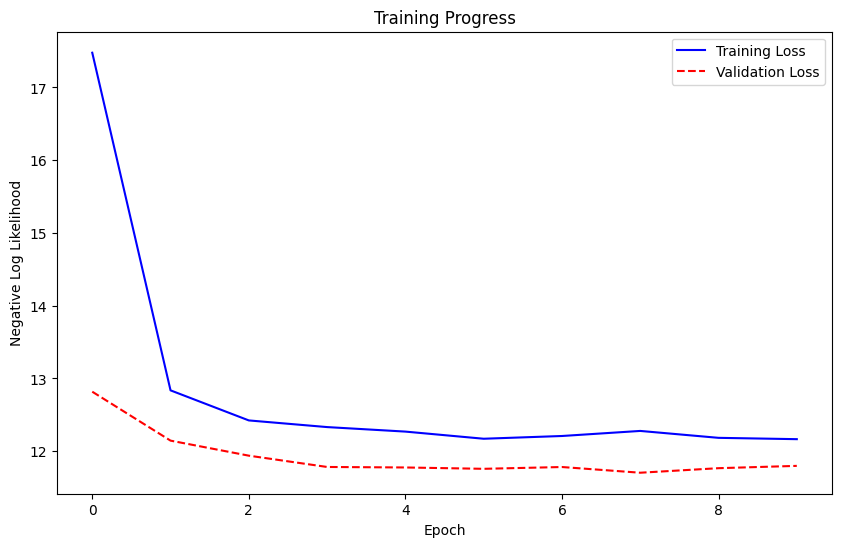

Validation set UAS: 0.1294
Test set UAS: 0.2969
Validation set DDA: 0.1600
Test set DDA: 0.3703


In [ ]:

import matplotlib.pyplot as plt

def train(model, train_loader, dev_loader, optimizer, device, num_epochs):
  """
    Trains a neural dependency model for a specified number of epochs.

    Args:
        model: The neural dependency model to train
        train_loader: DataLoader providing training batches
        dev_loader: DataLoader providing validation batches
        optimizer: PyTorch optimizer for parameter updates
        device: Device to run computations on ('cpu' or 'cuda')
        num_epochs: Number of training epochs to run

    Returns:
        model: The trained model
    """
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):

    train_loss = train_em(model, train_loader, optimizer, device, evaluate = False)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f} | ")

    val_loss = train_em(model, train_loader, optimizer, device, evaluate = True)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1} | "
              f"Validation Loss: {val_loss:.4f} | ")




    # Plot training curve
  plt.figure(figsize=(10, 6))
  #plt.plot(train_losses, label='Training Loss')
  plt.plot(train_losses, label='Training Loss', color='blue')
  plt.plot(val_losses, label='Validation Loss', color='red', linestyle='dashed')
  plt.xlabel('Epoch')
  plt.ylabel('Negative Log Likelihood')
  plt.title('Training Progress')
  plt.legend()
  plt.show()

  return model


# Example usage
if __name__ == "__main__":
    # Initialize components
    data_module = SimpleDataModule(
        train_file="en_ewt-ud-train.conllu",
        val_file="en_ewt-ud-dev.conllu",
        test_file="en_ewt-ud-test.conllu",
    )

    train_loader, val_loader, _ = create_dataloaders(data_module)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = NDMV_Biaffine(
        pos_vocab=data_module.pos_vocab,
        pos_emb_size=100,
        hidden_size=256,
        device=device
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


    # Run training
    trained_model = train(
        model=model,
        train_loader=train_loader,
        dev_loader = val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=10
    )

    dev_uas = eval_for_uas(trained_model, val_loader, device)
    test_uas = eval_for_uas(trained_model, test_loader, device)
    dev_dda = eval_for_dda(trained_model, val_loader, device)
    test_dda = eval_for_dda(trained_model, test_loader, device)

    #print(f"Validation set UAS: {dev_uas:.4f}")
    print(f"Test set UAS: {test_uas:.4f}")

    #print(f"Validation set DDA: {dev_dda:.4f}")
    print(f"Test set DDA: {test_dda:.4f}")

Epoch 1 | Train Loss: 25.6018 | 
Epoch 1 | Validation Loss: 18.3500 | 
Epoch 2 | Train Loss: 16.3642 | 
Epoch 2 | Validation Loss: 13.8207 | 
Epoch 3 | Train Loss: 13.5215 | 
Epoch 3 | Validation Loss: 12.2200 | 
Epoch 4 | Train Loss: 12.3970 | 
Epoch 4 | Validation Loss: 11.5608 | 
Epoch 5 | Train Loss: 11.8714 | 
Epoch 5 | Validation Loss: 11.1297 | 
Epoch 6 | Train Loss: 11.4927 | 
Epoch 6 | Validation Loss: 10.8743 | 
Epoch 7 | Train Loss: 11.2559 | 
Epoch 7 | Validation Loss: 10.7283 | 
Epoch 8 | Train Loss: 11.1674 | 
Epoch 8 | Validation Loss: 10.5960 | 
Epoch 9 | Train Loss: 11.1091 | 
Epoch 9 | Validation Loss: 10.6046 | 
Epoch 10 | Train Loss: 10.9808 | 
Epoch 10 | Validation Loss: 10.5028 | 


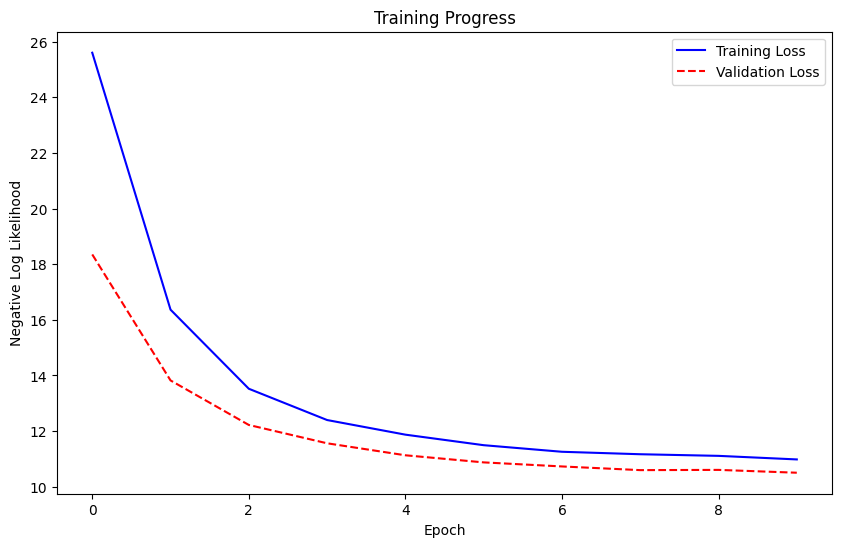

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:

import matplotlib.pyplot as plt

def train(model, train_loader, dev_loader, optimizer, device, num_epochs):
  """
    Trains a neural dependency model for a specified number of epochs.

    Args:
        model: The neural dependency model to train
        train_loader: DataLoader providing training batches
        dev_loader: DataLoader providing validation batches
        optimizer: PyTorch optimizer for parameter updates
        device: Device to run computations on ('cpu' or 'cuda')
        num_epochs: Number of training epochs to run

    Returns:
        model: The trained model
    """
  train_losses = []
  val_losses = []

  for epoch in range(num_epochs):

    train_loss = train_em(model, train_loader, optimizer, device, evaluate = False)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1} | "
              f"Train Loss: {train_loss:.4f} | ")

    val_loss = train_em(model, train_loader, optimizer, device, evaluate = True)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1} | "
              f"Validation Loss: {val_loss:.4f} | ")




    # Plot training curve
  plt.figure(figsize=(10, 6))
  #plt.plot(train_losses, label='Training Loss')
  plt.plot(train_losses, label='Training Loss', color='blue')
  plt.plot(val_losses, label='Validation Loss', color='red', linestyle='dashed')
  plt.xlabel('Epoch')
  plt.ylabel('Negative Log Likelihood')
  plt.title('Training Progress')
  plt.legend()
  plt.show()

  return model


# Example usage
if __name__ == "__main__":
    # Initialize components
    data_module = SimpleDataModule(
        train_file="hi_hdtb-ud-train.conllu",
        val_file="hi_hdtb-ud-dev.conllu",
        test_file="hi_hdtb-ud-test.conllu",
    )

    train_loader, val_loader, _ = create_dataloaders(data_module)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = NDMV_Biaffine(
        pos_vocab=data_module.pos_vocab,
        pos_emb_size=100,
        hidden_size=256,
        device=device
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
    #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')


    # Run training
    trained_model = train(
        model=model,
        train_loader=train_loader,
        dev_loader = val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=10
    )

    dev_uas = eval_for_uas(trained_model, val_loader, device)
    test_uas = eval_for_uas(trained_model, test_loader, device)
    dev_dda = eval_for_dda(trained_model, val_loader, device)
    test_dda = eval_for_dda(trained_model, test_loader, device)

    print(f"Validation set UAS: {dev_uas:.4f}")
    print(f"Test set UAS: {test_uas:.4f}")

    print(f"Validation set DDA: {dev_dda:.4f}")
    print(f"Test set DDA: {test_dda:.4f}")